In [1]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [2]:
def count_folders(filepath):
    return len([name for name in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, name))])

# Example usage
directory_path = '../data/series_train.parquet'
num_folders = count_folders(directory_path)
print(f"Number of folders in '{directory_path}': {num_folders}")

Number of folders in '../data/series_train.parquet': 996


In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [4]:
train_ts = load_time_series('../data/series_train.parquet')

  0%|          | 0/996 [00:00<?, ?it/s]

100%|██████████| 996/996 [00:32<00:00, 30.84it/s]


In [5]:
df_train = pd.read_csv('../data/train.csv')

In [6]:
data_dic = pd.read_csv('../data/data_dictionary.csv')

In [7]:
pd.read_parquet('/Data/victor.zhuang/Code/Child Mind Institute Competition/data/series_train.parquet/id=0a418b57/part-0.parquet')

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,-0.075242,-0.256743,-0.973791,0.038081,-72.952141,0.0,5.0,4202.000000,51250000000000,2,4,-9.0
1,1,-0.265893,-0.270508,-0.765470,0.077430,-52.849220,0.0,0.5,4185.333496,51255000000000,2,4,-9.0
2,2,0.334517,-0.548602,-0.588596,0.039162,-44.118084,0.0,11.5,4185.500000,51260000000000,2,4,-9.0
3,3,0.000193,-0.021069,-0.999681,0.001450,-88.759613,0.0,0.0,4185.666504,51265000000000,2,4,-9.0
4,4,-0.000685,-0.020681,-0.997677,0.000491,-88.756958,0.0,8.5,4185.833496,51270000000000,2,4,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213418,213418,0.391111,0.658119,-0.511350,0.060158,-35.455124,0.0,22.0,3817.430664,38745000000000,1,4,25.0
213419,213419,0.551039,0.078267,-0.787324,0.094029,-52.621586,0.0,22.0,3817.430664,38750000000000,1,4,25.0
213420,213420,0.667007,-0.126560,-0.751950,0.013104,-47.961002,0.0,22.0,3817.430664,39015000000000,1,4,25.0
213421,213421,0.666465,-0.125810,-0.749048,0.010495,-47.928806,0.0,22.0,3817.430664,39020000000000,1,4,25.0


In [8]:
train = df_train[['sii', 'id']].merge(train_ts, on='id')
train = train.drop('id', axis=1)

In [9]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 3*hidden_dim)
        self.fc2 = nn.Linear(3*hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, latent_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.relu(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 2*hidden_dim)
        self.fc2 = nn.Linear(2*hidden_dim, 3*hidden_dim)
        self.fc3 = nn.Linear(3*hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        # x = torch.relu(x)
        # x = torch.softmax(x, dim=1)
        # x = torch.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
epochs = 100
input_dim = train.shape[1] - 1
hidden_dim = 100
latent_dim = 50
num_classes = 4

model = Autoencoder(input_dim, hidden_dim, latent_dim, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloader = DataLoader(train.values, batch_size=32, shuffle=True)

for epoch in range(epochs):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch = batch.to(device)

        features = batch[:,1:].float()
        labels = batch[:,0].long()

        output = model(features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
        if i % 20 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")


Epoch: 0, Loss: 68627726336.0
Epoch: 0, Loss: 45985718272.0
Epoch: 1, Loss: 12881293312.0
Epoch: 1, Loss: 9073615872.0
Epoch: 2, Loss: 3370209792.0
Epoch: 2, Loss: 1.3034238815307617
Epoch: 3, Loss: 1.3020063638687134
Epoch: 3, Loss: 1.1265068054199219
Epoch: 4, Loss: 1.0292609930038452
Epoch: 4, Loss: 0.8498300313949585
Epoch: 5, Loss: 0.8525803685188293
Epoch: 5, Loss: 0.9720287919044495
Epoch: 6, Loss: 0.9940359592437744
Epoch: 6, Loss: 1.0113818645477295
Epoch: 7, Loss: 1.0597691535949707
Epoch: 7, Loss: 1.0888298749923706
Epoch: 8, Loss: 0.9456992745399475
Epoch: 8, Loss: 0.8728296160697937
Epoch: 9, Loss: 1.1548047065734863
Epoch: 9, Loss: 0.8090616464614868
Epoch: 10, Loss: 1.0890377759933472
Epoch: 10, Loss: 0.9483433365821838
Epoch: 11, Loss: 1.2025179862976074
Epoch: 11, Loss: 1.0085171461105347
Epoch: 12, Loss: 0.9172411561012268
Epoch: 12, Loss: 0.887688159942627
Epoch: 13, Loss: 1.049769639968872
Epoch: 13, Loss: 0.8661693334579468
Epoch: 14, Loss: 0.7942559719085693
Epoch

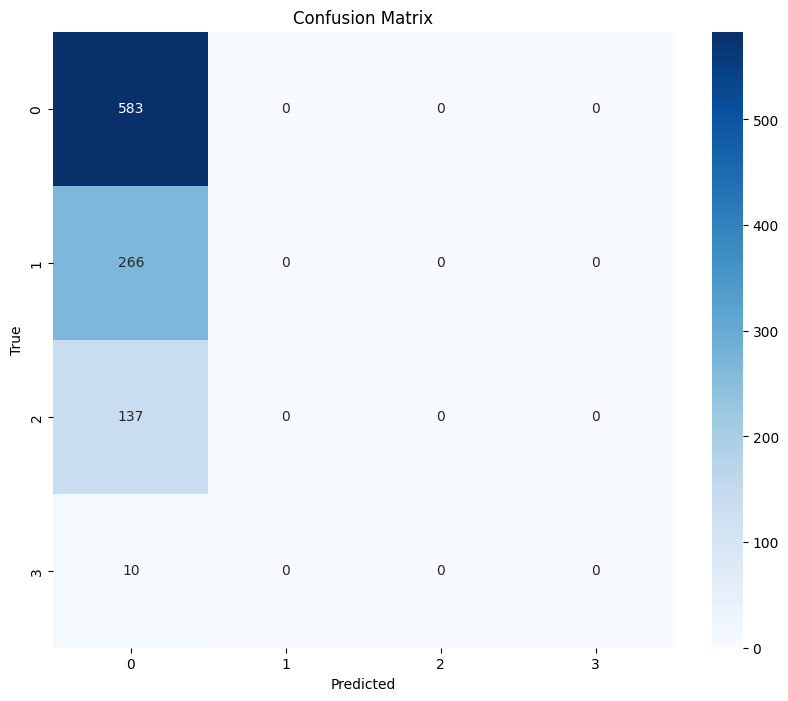

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        features = batch[:, 1:].float()
        labels = batch[:, 0].long()
        
        # Get model predictions
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        
        # Store true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

